# Predict health status misrepresentation
reference number: 4234337

objective: Identify misrepresentation in survey by predicting respondent's health status for Diabetes 



# Content: 
1. Data cleaning and exploratory analysis
2. Diabetes detection model
3. Improving diabetes detection model 
4. Identify misrepresentations
5. Experiment with Neural Network for diabetes prediction

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np 

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, recall_score, precision_score,f1_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.cross_validation import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

plt.style.use('seaborn-deep')
%matplotlib inline


/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data cleaning and exploratory analysis

1. remove columns with constant value 
2. remove columns with over 30% of NA vaues
3. remove variables with high collinearity
4. look at the distribution of predicted class(Yes/No)

In [2]:
#specify the encoding ='cp1252' to read in the data correctly
df = pd.read_csv('SBU_example_Surveydata_2014.csv',encoding='cp1252')
df.head()

,STATE,GEOSTR,DENSTR2,PRECALL,REPNUM,REPDEPTH,FMONTH,IDATE,IMONTH,IDAY,...,HCVPRIME,HCVPRIMA,HLTHPREG,PREGEVER,BRTHCNTL3,TYPCNTRL2,NOBCUSE2,PFCHLDFT,PRNTLVIT,REGION
0,New York,201,D,To be called,40136,28,April,4252014,4,25,...,Not asked or Missing,Not asked or Missing,Not asked or Missing,Not asked or Missing,NaN,NaN,NaN,Not asked or Missing,NaN,NYS exclusive of NYC
1,New York,202,D,To be called,10105,17,January,3162014,3,16,...,Not asked or Missing,Not asked or Missing,Not asked or Missing,Not asked or Missing,NaN,NaN,NaN,Not asked or Missing,NaN,New York City (NYC)
2,New York,201,D,To be called,110014,4,November,11292014,November,29,...,Not asked or Missing,Not asked or Missing,Not asked or Missing,Not asked or Missing,NaN,NaN,NaN,Not asked or Missing,NaN,NYS exclusive of NYC
3,New York,201,D,To be called,110083,6,November,11252014,November,25,...,Not asked or Missing,Not asked or Missing,Not asked or Missing,Not asked or Missing,NaN,NaN,NaN,Not asked or Missing,NaN,NYS exclusive of NYC
4,New York,202,D,To be called,50129,7,May,10052014,October,5,...,Not asked or Missing,Not asked or Missing,Not asked or Missing,Not asked or Missing,NaN,NaN,NaN,Not asked or Missing,NaN,New York City (NYC)


In [3]:
#detect the columns that has a constant value
constant_columns = []
for i in df.columns:
    if len(df[i].unique()) ==1:
        constant_columns.append(i)
 

#detect columns with more than 30% NAs
nas_columns = []
for i in df.columns:
    if sum(df[i].isnull())/len(df[i]) > 0.3 :
        nas_columns.append(i)
        

#remove meaningless columns based on the description from data dictionary
meaningless_columns = ['DENSTR2','PRECALL','REPNUM', 'REPDEPTH', 'FMONTH','IDATE', 'IMONTH', 'IDAY',
                       'IYEAR','SEQNO','PSU', 'NATTMPTS', 'NRECSTR','PVTRESD1','COLGHOUS','STATERES','CELLFON3',
                       'LADULT','DISPCODE','NRECSEL','NRECSTR','PVTRESD1','NUMADULT']

        
removed_columns = constant_columns +nas_columns+meaningless_columns
df.drop(columns = removed_columns, inplace = True)

In [4]:
# create the df_y dataframe
df_y = df['DIABETE3']

# remove the DIABETE3 column from the initial
df.drop('DIABETE3', axis=1, inplace=True)

# convert the categorical values to dummies and add the DIABETE3 column
df_x =pd.get_dummies(df, drop_first=True)


In [5]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] 
    return(dataset)

df_xnew = correlation(df_x,0.75)

In [6]:
#append DIABETE3 columns to df_xnew dataframe
df_new = pd.concat([df_xnew, df_y], axis =1 )
df_new.head()

,GEOSTR,GENHLTH_Excellent,GENHLTH_Fair,GENHLTH_Good,GENHLTH_Poor,GENHLTH_Refused,GENHLTH_Very good,PHYSHLTH_None,PHYSHLTH_Refused,MENTHLTH_None,...,HCVPRIME_Refused,HCVPRIME_Yes,HCVPRIMA_Not sure/dont know,HLTHPREG_Not asked or Missing,HLTHPREG_Not sure/dont know,HLTHPREG_Refused,HLTHPREG_Yes,PREGEVER_Refused,REGION_New York City (NYC),DIABETE3
0,201,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,No
1,202,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,1,No
2,201,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,No
3,201,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,No
4,202,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,No


In [7]:
df_new.DIABETE3.value_counts()

No                                           5848
Yes                                           842
No pre-diabetes or borderline diabetes        110
Yes but female told only during pregnancy      51
Refused                                         7
Don’t know/Not Sure                             7
Name: DIABETE3, dtype: int64

In [8]:
#The response variable has six categories, and the classes are significantly imbalanced. 
# People are less likely to provide false information in the four minority classes, 
#["No pre-diabetes or borderline diabetes ","Yes but female told only during pregnancy","Refused",
#"Don’t know/Not Sure"]
#So in this model, we are only going to use yes and no cases to predict diabetes

df_binary = df_new[df_new.DIABETE3.isin(['No','Yes'])]
df_binary.DIABETE3.value_counts()

No     5848
Yes     842
Name: DIABETE3, dtype: int64

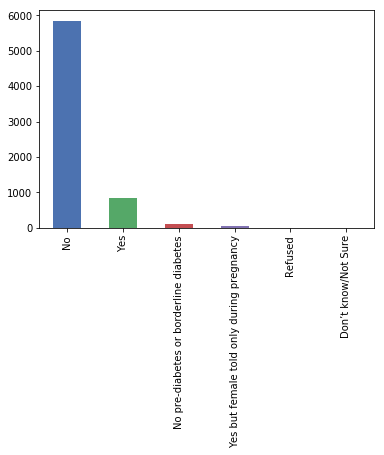

In [9]:
pd.value_counts(df_new.DIABETE3.values, sort=True).plot.bar()

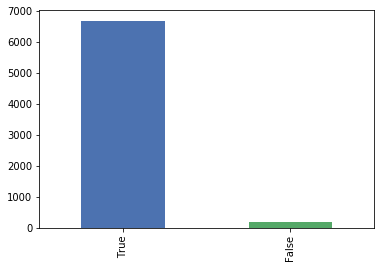

In [10]:
pd.value_counts(df_new.DIABETE3.isin(['No','Yes']).values, sort=True).plot.bar()

# Base model selection
Preliminary model selection among
logistic regression, random forest, svm, naive bayes, KNN

In [11]:
#split into train and test
y = df_binary['DIABETE3']
X= df_binary.drop(columns =['DIABETE3'])
X_train,X_test,y_train,y_test  =train_test_split(X,y,  test_size=0.3)

In [12]:
def scorematrix(X_train,y_train,X_test,y_test):
    models = [RandomForestClassifier(), GaussianNB(), SVC(class_weight = 'balanced'), KNeighborsClassifier(), LogisticRegression()]
    modelnames = ['RandomForest', 'GaussianNB','SVC','Kneighbors','LogisticRegression']

    scorenames = ['precision','recall','f1','accuracy']
    precision = []
    recall =[]
    f1 = []
    accuracy = []

    for model in models:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        precision.append(precision_score(y_test,y_pred, average = 'weighted'))
        recall.append(recall_score(y_test,y_pred,average = 'weighted'))
        f1.append(f1_score(y_test,y_pred,average = 'weighted'))
        accuracy.append(accuracy_score(y_test,y_pred))

    scores_df = pd.DataFrame({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy})
    scores_df.set_index([modelnames], inplace = True)

    return scores_df

In [13]:
scorematrix(X_train,y_train,X_test,y_test)
#From the score matrix we can see that radom forest and linear regression performs better than other algorithms.
# Naive Bayes, it performed very poorly because of the feature independence assumption
# I eliminated SVC and Kneighbors because of its low accuracy/precision/recall score and lack of interpretability
#below we will do a bit more investigation on logistic regression and random forest

,accuracy,f1,precision,recall
RandomForest,0.917289,0.903727,0.915454,0.917289
GaussianNB,0.599402,0.661654,0.892148,0.599402
SVC,0.827603,0.850345,0.906390,0.827603
Kneighbors,0.878426,0.851406,0.853054,0.878426
LogisticRegression,0.929248,0.922944,0.925154,0.929248


In [14]:
#logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print (accuracy_score(y_test,predictions))
print(metrics.classification_report(y_test,predictions))

0.9292476332835077
             precision    recall  f1-score   support

         No       0.94      0.98      0.96      1746
        Yes       0.84      0.56      0.67       261

avg / total       0.93      0.93      0.92      2007



In [15]:
# if you use the logistic model on X train, we get about 94% accuracy, indicating there are some misrepresentation 
#in the data
predictions = model.predict(X_train)
print(metrics.classification_report(y_train,predictions))

             precision    recall  f1-score   support

         No       0.94      0.99      0.97      4102
        Yes       0.88      0.59      0.70       581

avg / total       0.94      0.94      0.93      4683



In [16]:
#random forest
model = RandomForestClassifier()
model.fit(X_train,y_train)
predictions= model.predict(X_test)
print(metrics.classification_report(y_test,predictions))

             precision    recall  f1-score   support

         No       0.91      0.99      0.95      1746
        Yes       0.86      0.36      0.51       261

avg / total       0.91      0.91      0.89      2007



# Result
Logistic regresion and random forest outperformed other algorithms. 

Naive Bayes performed poorly because this data doesn't follow the assumption that features are independent from each other

I eliminated KNN, SVM due to its low performance and lack of iterpretability. 

In the next model improvement section, we will perform improvement on Logistic regression and random forest model


# Model Improvement
1. Use smote sampling to see how model performs in balanced classes
2. Tune hyper parameter for logistic regression and random forest

In [17]:
#The classes are significantly imbalanced, going to perform smote sampling before fitting any models
smote = SMOTE(kind = "regular")
X_smtrain, y_smtrain = smote.fit_sample(X_train, y_train)

In [18]:
#grid search on logistic regression
grid = {'C': np.power(10.0, np.arange(-10, 10))}
clf = LogisticRegression(penalty='l2', random_state=777, max_iter=10000)
gs = GridSearchCV(clf, grid, cv=5)
gs.fit(X_smtrain, y_smtrain)
gs.best_params_

{'C': 1.0}

In [19]:
#randomized search on random forest hyperparameters

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=1)
# Fit the random search model
rf_random.fit(X_train,y_train)


rf_random.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.0min finished


{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 600}

In [20]:
rfmodel = RandomForestClassifier(max_depth = 110, max_features = 'auto',min_samples_leaf = 1,min_samples_split=5,n_estimators=1800)
rfmodel.fit(X_smtrain, y_smtrain)
rfpredictions = rfmodel.predict(X_test)
print(metrics.classification_report(y_test,rfpredictions))

             precision    recall  f1-score   support

         No       0.93      0.98      0.96      1746
        Yes       0.83      0.51      0.64       261

avg / total       0.92      0.92      0.92      2007



In [21]:
lrmodel = LogisticRegression(C=10000)
lrmodel.fit(X_smtrain, y_smtrain)
lrpredictions = lrmodel.predict(X_test)
print(metrics.classification_report(y_test,lrpredictions))

             precision    recall  f1-score   support

         No       0.97      0.87      0.92      1746
        Yes       0.49      0.82      0.61       261

avg / total       0.91      0.87      0.88      2007



In [22]:
def cm(y_test,y_pred):
    cmdata = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(cmdata, index = ['yes','no'],
                                 columns = ['yes','no'])
    plt.figure (figsize = (10,7))
    sn.heatmap(df_cm,annot = True , annot_kws={'size':16}, fmt='g')

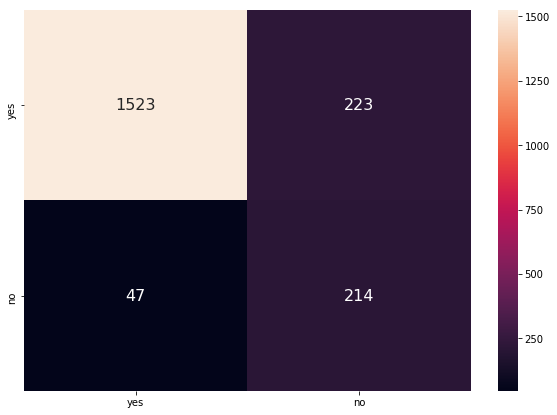

In [23]:
#logistic regression model confusion matrix
cm(y_test,lrpredictions)

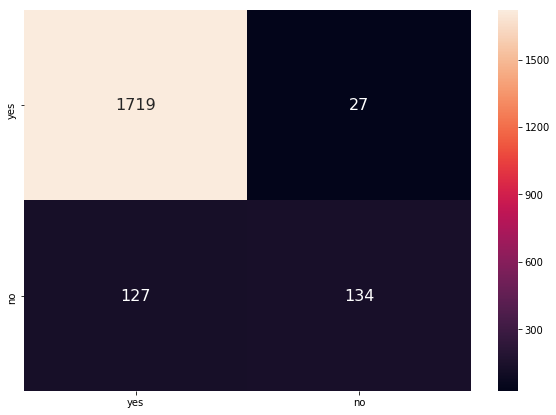

In [24]:
#random forest model confusion matrix 
cm(y_test,rfpredictions)

In [25]:
#As we can see from the accuracy report and confusion matrix
#random forest performs better than logistic regression

# Misrepresentation modeling

In [26]:
#append non-binary values next to the test dataframe to see the misrepresentation
df.non_binary = df_new[df_new.DIABETE3.isin(['No pre-diabetes or borderline diabetes','Yes but female told only during pregnancy',
                                            'Don’t know/Not Sure','Refused'])]
df.non_binaryx = df.non_binary.drop(columns = ['DIABETE3'])
df.non_binaryy = df.non_binary.DIABETE3

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [27]:
X_testnew = X_test.append(df.non_binaryx)
y_testnew = y_test.append(df.non_binaryy)

In [28]:
predictions = rfmodel.predict(X_testnew)
output = pd.DataFrame({'actual':y_testnew, 'predictions':predictions})
output.groupby(['actual','predictions']).size().reset_index()
#this table gives us a a good idea of misrepresentation in the survey data

,actual,predictions,0
0,Don’t know/Not Sure,No,7
1,No,No,1719
2,No,Yes,27
3,No pre-diabetes or borderline diabetes,No,94
4,No pre-diabetes or borderline diabetes,Yes,16
5,Refused,No,6
6,Refused,Yes,1
7,Yes,No,127
8,Yes,Yes,134
9,Yes but female told only during pregnancy,No,49


In [29]:
#misrepresentation rate are the answers that are different from actual informations
(24+15+120+50)/2182

#misrepresentation rate in the entire survey is about 10%
#More specifically, about 48% of people who claimed with diabetes actually don't have diabetes
# about 1.4% of people who said they don't have diabetes is likely to have diabetes according to the model

0.09578368469294225

([<matplotlib.axis.XTick at 0x1a11df5ba8>,
 <a list of 9 Text xticklabel objects>)

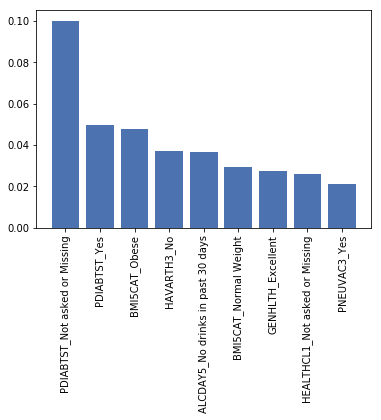

In [30]:
#now let's take a look at the top 10 important features that leads to diabetes
importances = rfmodel.feature_importances_
flist = sorted([(v, list(X_train.columns)[i]) for i,v in enumerate(importances)],reverse=True)
fim1 = [i[0] for i in flist]
fname =[i[1] for i in flist]
plt.bar(np.linspace(1,9,9) ,fim1[:9], align = 'center')
plt.xticks(np.linspace(1,9,9),fname[:9], rotation =90)



 # Neural Network predictions

In [31]:
import tensorflow as tf
from six.moves import range

%config InlineBackend.figure_format = 'retina'



from tensorflow.contrib import keras
from keras import models, layers, losses, optimizers, metrics

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



/Users/windflower715/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/windflower715/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [34]:
y_train[y_train == 'No'] = 0
y_train[y_train == 'Yes'] = 1
y_test[y_test == 'No'] = 0
y_test[y_test == 'Yes'] = 1


In [35]:
model2 = models.Sequential()
model2.add(layers.Dense(100, input_dim=220, activation='relu')) 
model2.add(layers.Dense(527, activation='relu'))
model2.add(layers.Dense(320, activation='relu'))
model2.add(layers.Dense(320, activation='relu'))
model2.add(layers.Dense(320, activation='relu'))
model2.add(layers.Dense(115, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#set up early stopping to prevent overfitting 
cb=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

model2.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), callbacks = [cb])

Train on 4683 samples, validate on 2007 samples
Epoch 1/25
4683/4683 [==============================] - 3s 640us/step - loss: 0.3789 - acc: 0.8710 - val_loss: 0.3097 - val_acc: 0.8824
Epoch 2/25
4683/4683 [==============================] - 2s 401us/step - loss: 0.2904 - acc: 0.8879 - val_loss: 0.2620 - val_acc: 0.8809
Epoch 3/25
4683/4683 [==============================] - 2s 389us/step - loss: 0.2332 - acc: 0.9069 - val_loss: 0.2200 - val_acc: 0.9078
Epoch 4/25
4683/4683 [==============================] - 2s 360us/step - loss: 0.2083 - acc: 0.9107 - val_loss: 0.1915 - val_acc: 0.9208
Epoch 5/25
4683/4683 [==============================] - 2s 406us/step - loss: 0.2143 - acc: 0.9165 - val_loss: 0.1974 - val_acc: 0.9208
Epoch 6/25
4683/4683 [==============================] - 2s 383us/step - loss: 0.1888 - acc: 0.9246 - val_loss: 0.1875 - val_acc: 0.9273
Epoch 7/25
4683/4683 [==============================] - 2s 374us/step - loss: 0.1812 - acc: 0.9278 - val_loss: 0.2898 - val_acc: 0.9153
